In this notebook we created the preliminary code for in/Out classifier to find if animal is going inside or outside the fence via the hatch. This task is complicated becasuse we found out that we need to emphasize the positioning of the animal and the hatch. Therefore we needed to detect also the hatch. Our efforts to train object detection models to find the hatch didn't give good results so we used *Segment Anything* (SAM)

In [ ]:
!pip install -r requirements_gpu.txt --quiet
!pip install dropbox --quiet
!pip install fastai --quiet
!pip install fastdup --quiet
!pip install imageai --upgrade --quiet

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements_gpu.txt'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.0/594.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [ ]:
import dropbox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tempfile
import os
import shutil
import fastdup
import cv2
import numpy as np
import torch

In [ ]:
#create connection to dropbox
dbx_api_key = "!"
dbx = dropbox.Dropbox(dbx_api_key)

## Donwload relevant folders and Pre-Process the Data

In [ ]:
def read_from_dropbox(csv_path: str) -> pd.DataFrame:
    """
    Reads a CSV file from Dropbox given its path.
    """
    _, temp_file_path = tempfile.mkstemp()
    dbx.files_download_to_file(temp_file_path, csv_path)
    return pd.read_csv(temp_file_path)

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the given DataFrame by adding timestamps and episode_number columns.
    """
    df['timestamps'] = pd.to_datetime(df['DateTime'])
    time_diff = df['timestamps'].diff()

    threshold = 1
    start_new_episode = time_diff > pd.Timedelta(minutes=threshold)
    episode_number = start_new_episode.cumsum()
    df['episode_number'] = episode_number
    return df

# Usage:
csv_path = '/SUMMER 2023 animals only/Border Mammals Summer Results Raw Data.csv'
df = read_from_dropbox(csv_path)
df = preprocess_dataframe(df)
df.head(10)

,RootFolder,File,RelativePath,DateTime,DeleteFlag,Season,Day_Night,Mammal,Counter,Remarks,Episode,Direction,Unnamed: 12,timestamps,episode_number
0,SUMMER 2023 animals only,IMG_0022.JPG,2030,2023-07-11 18:02:22,False,Summer,Day,Bird,1,Spur-winged lapwing (sik sak),False,Pass,NaN,2023-07-11 18:02:22,0
1,SUMMER 2023 animals only,IMG_0023.JPG,2030,2023-07-11 18:02:24,False,Summer,Day,Bird,0,Spur-winged lapwing (sik sak),False,Pass,NaN,2023-07-11 18:02:24,0
2,SUMMER 2023 animals only,IMG_0025.JPG,2030,2023-07-12 00:21:20,False,Summer,Night,Jackal,1,NaN,False,In,NaN,2023-07-12 00:21:20,1
3,SUMMER 2023 animals only,IMG_0070.JPG,2030,2023-07-19 08:01:22,False,Summer,Day,Bird,1,NaN,False,Pass,NaN,2023-07-19 08:01:22,2
4,SUMMER 2023 animals only,IMG_0127.JPG,2030,2023-07-22 08:54:08,False,Summer,Day,Dog,1,NaN,False,Pass,NaN,2023-07-22 08:54:08,3
5,SUMMER 2023 animals only,IMG_0130.JPG,2030,2023-07-23 00:49:46,False,Summer,Night,Bird,1,Eurasian stone-curlew,True,Pass,NaN,2023-07-23 00:49:46,4
6,SUMMER 2023 animals only,IMG_0131.JPG,2030,2023-07-23 00:49:48,False,Summer,Night,Bird,0,Eurasian stone-curlew,True,Pass,NaN,2023-07-23 00:49:48,4
7,SUMMER 2023 animals only,IMG_0132.JPG,2030,2023-07-23 00:49:50,False,Summer,Night,Bird,0,Eurasian stone-curlew,True,Pass,NaN,2023-07-23 00:49:50,4
8,SUMMER 2023 animals only,IMG_0136.JPG,2030,2023-07-24 06:22:43,False,Summer,Day,Dog,1,NaN,True,Pass,NaN,2023-07-24 06:22:43,5
9,SUMMER 2023 animals only,IMG_0137.JPG,2030,2023-07-24 06:22:43,False,Summer,Day,Dog,0,NaN,True,Pass,NaN,2023-07-24 06:22:43,5


In [ ]:
df['Direction'].unique()

array(['Pass', 'In', 'Out', nan], dtype=object)

<BarContainer object of 4 artists>

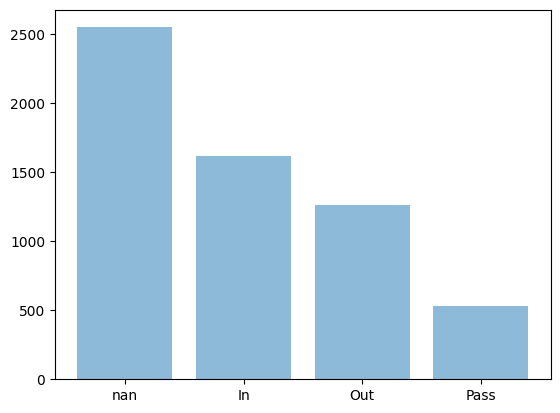

In [ ]:
category_counts = df['Direction'].value_counts(dropna=False)
plt.bar(['nan', 'In', 'Out', 'Pass'], category_counts.values, align='center', alpha=0.5)

In [ ]:
category_counts

Out     2550
In      1615
Pass    1265
NaN      532
Name: Direction, dtype: int64

We will train the classifier over 100 pictures from every category

### Get Animals Images from DropBox

In [ ]:
!mkdir ./animal_pics

!mkdir ./animal_pics/in
!mkdir ./animal_pics/out
!mkdir ./animal_pics/pass
!mkdir ./animal_pics/nan

In [ ]:
local_dirs = {
    'In': './animal_pics/in',
    'Out': './animal_pics/out',
    'nan': './animal_pics/nan',
    'Pass': './animal_pics/pass'
}

In [ ]:
def get_direction(df, picture):
    return df[df['File'] == picture].iloc[0]['Direction']

def download_animal_images(df, base_folder_path, local_dirs):
    """
    Downloads animal images from Dropbox to local directories based on animal type.

    Args:
    - df (pd.DataFrame): DataFrame containing relative paths and other necessary columns.
    - base_folder_path (str): Base folder path in Dropbox.
    - local_dirs (dict): Dictionary mapping animal names to local directory paths.
    """
    num_nan = 0
    num_in = 0
    num_out = 0
    num_pass = 0

    for r_path in df['RelativePath'].unique():
        folder_path = os.path.join(base_folder_path, r_path)
        filterd_df = df[df['RelativePath'] == r_path]

        # List files in the folder

        result = dbx.files_list_folder(folder_path, limit=1000)

        for entry in result.entries:
            # Only process files, skip directories or other types of entries
            if not isinstance(entry, dropbox.files.FileMetadata):
                continue

            file_path = os.path.join(folder_path, entry.name)
            direction_type = get_direction(filterd_df, str(entry.name))

            # Get pictures and the local directory for every category (100 pictures each)
            local_dir = local_dirs.get(direction_type)
            if local_dir is not None and direction_type == 'In' and num_in < 100:
                new_name = f'{r_path}_{entry.name}'
                local_path = os.path.join(local_dir, new_name)
                try:
                    dbx.files_download_to_file(local_path, file_path)
                    num_in = num_in+1
                except dropbox.exceptions.ApiError as e:
                    print(f"Error downloading {file_path}: {e}")
            elif local_dir is not None and direction_type == 'Out' and num_out < 100:
                new_name = f'{r_path}_{entry.name}'
                local_path = os.path.join(local_dir, new_name)
                try:
                    dbx.files_download_to_file(local_path, file_path)
                    num_out = num_out+1
                except dropbox.exceptions.ApiError as e:
                    print(f"Error downloading {file_path}: {e}")
            elif local_dir is not None and direction_type == 'Pass' and num_pass < 100:
                new_name = f'{r_path}_{entry.name}'
                local_path = os.path.join(local_dir, new_name)
                try:
                    dbx.files_download_to_file(local_path, file_path)
                    num_pass = num_pass+1
                except dropbox.exceptions.ApiError as e:
                    print(f"Error downloading {file_path}: {e}")
            else:
                if num_nan <100:
                  new_name = f'{r_path}_{entry.name}'
                  local_path = os.path.join(local_dirs['nan'], new_name)
                  try:
                      dbx.files_download_to_file(local_path, file_path)
                      num_nan = num_nan+1
                  except dropbox.exceptions.ApiError as e:
                      print(f"Error downloading {file_path}: {e}")

In [ ]:
images_path = "/SUMMER 2023 animals only/"
download_animal_images(df, images_path, local_dirs)

In [ ]:
(len(os.listdir('/content/animal_pics/in')))

100

In [ ]:
(len(os.listdir('/content/animal_pics/out')))

100

In [ ]:
(len(os.listdir('/content/animal_pics/nan')))

100

In [ ]:
(len(os.listdir('/content/animal_pics/pass')))

100

# Segmentation with SAM

## SAM model loading

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-01itows7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-01itows7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=5f576ab3f6fed363dfedc703ec64d7c00ec2018449a832f735b5797c86cddae6
  Stored in directory: /tmp/pip-ephem-wheel-cache-alk9_ey1/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-22 16:17:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.106, 52.84.251.15, 5

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def show_anns(anns):
    # If there are no annotations, exit the function early
    if len(anns) == 0:
        return

    # Sort the annotations by area in descending order
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    # Get the current axis (plot) on which to draw
    ax = plt.gca()
    # Disable autoscaling of the axis
    ax.set_autoscale_on(False)

    # Create a transparent image of the same size as the first (largest) annotation
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    # Loop over each annotation
    for ann in sorted_anns:
        # Get the mask for this annotation
        m = ann['segmentation']

        # Generate a random color for this mask (RGB + alpha, where alpha is 0.35)
        color_mask = np.concatenate([np.random.random(3), [0.35]])

        # Apply the color to the mask on the image
        img[m] = color_mask

    # Display the image with the colored masks
    ax.imshow(img)
    pred_argmax = img
    rescaled = (255.0/pred_argmax.max() * (pred_argmax - pred_argmax.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)

    # save the mask as picture
    im.save('masks.png')

## Save the picture with it's segmentation layer

In [ ]:
!mkdir ./SAM_animal_pics

!mkdir ./SAM_animal_pics/in
!mkdir ./SAM_animal_pics/out
!mkdir ./SAM_animal_pics/pass
!mkdir ./SAM_animal_pics/nan

In [ ]:
sam_dirs = {
    'in': './SAM_animal_pics/in',
    'out': './SAM_animal_pics/out',
    'nan': './SAM_animal_pics/nan',
    'pass': './SAM_animal_pics/pass'
}

In [ ]:
# combine the original picture with the segmentation "mask"
def combine_images(png_path, jpg_path, output_path):
    # Open the mask picture
    png_image = Image.open(png_path).convert("RGBA")

    # Open the original image
    jpg_image = Image.open(jpg_path).convert("RGBA")

    new_size = (224, 224)
    png_image = png_image.resize(new_size, Image.ANTIALIAS)
    jpg_image = jpg_image.resize(new_size, Image.ANTIALIAS)

    # Combine the images
    combined_image = Image.alpha_composite(jpg_image, png_image)

    # Save the combined image
    combined_image.save(output_path, format="PNG", quality=85)


In [ ]:
# loop on pictures to get the mask from SAM and save it as new image
for key in sam_dirs.keys():
  # read the pictures
  for pic in os.listdir(os.path.join('/content/animal_pics' ,key)):
    image_path = os.path.join('/content/animal_pics',key, pic)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #resizing
    resized_img = cv2.resize(image, (1000, 1000))
    #get the masks from SAM
    masks = mask_generator.generate(resized_img)
    show_anns(masks)
    # save the new image
    png_path = "/content/masks.png"
    jpg_path = image_path
    output_path = os.path.join('/content/SAM_animal_pics', key, pic)
    combine_images(png_path, jpg_path, output_path)

In [ ]:
(len(os.listdir('/content/SAM_animal_pics/in')))

100

In [ ]:
(len(os.listdir('/content/SAM_animal_pics/out')))

100

In [ ]:
(len(os.listdir('/content/SAM_animal_pics/nan')))

100

In [ ]:
(len(os.listdir('/content/SAM_animal_pics/pass')))

100

# Train classification fastai model

In [ ]:
!pip install fastdup

In [ ]:
from pathlib import Path
from fastai.vision.all import *

In [ ]:
path = Path("/content/SAM_animal_pics")
files = get_image_files(path)
len(files)

400

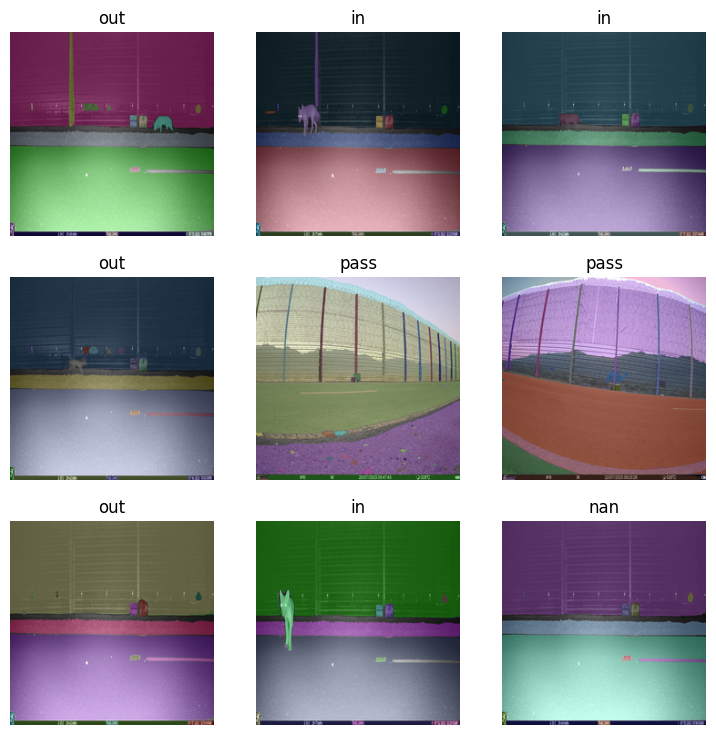

In [ ]:
import re

# load pictures
dls = ImageDataLoaders.from_folder(path, train="inOut", valid_pct =0.2,seed=10, item_tfms=Resize(224))
dls.show_batch()

Train the model

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[error_rate,accuracy])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 95.7MB/s]


SuggestedLRs(valley=0.0006918309954926372)

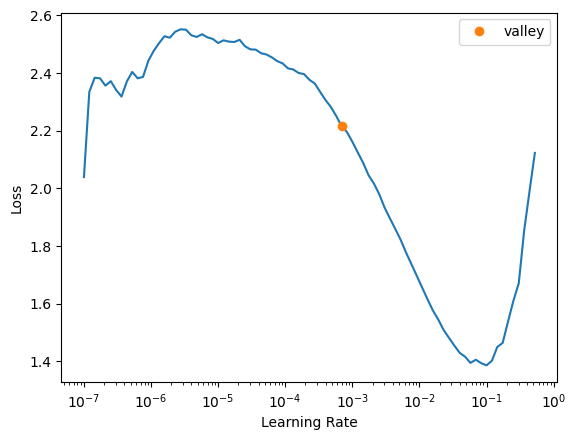

In [ ]:
# find the optimal learning rate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
learn.lr_find()

In [ ]:
learn.fine_tune(10, 0.0006918309954926372)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.508058,1.476087,0.550000,0.450000,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.938860,1.279180,0.475000,0.525000,00:03
1,1.733334,1.102198,0.425000,0.575000,00:02
2,1.442942,0.946841,0.412500,0.587500,00:02
3,1.189572,0.851753,0.362500,0.637500,00:03
4,0.989506,0.792956,0.362500,0.637500,00:03
5,0.841837,0.774208,0.350000,0.650000,00:03
6,0.727662,0.770058,0.375000,0.625000,00:02
7,0.631091,0.775524,0.350000,0.650000,00:03
8,0.553256,0.774956,0.350000,0.650000,00:03
9,0.491345,0.780915,0.362500,0.637500,00:02


In [ ]:
learn.fine_tune(20, 0.0006918309954926372)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.172733,0.782281,0.350000,0.650000,00:04


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.109485,0.774533,0.350000,0.650000,00:03
1,0.108801,0.775870,0.362500,0.637500,00:02
2,0.108559,0.784799,0.362500,0.637500,00:03
3,0.097746,0.794245,0.337500,0.662500,00:03
4,0.087262,0.763524,0.275000,0.725000,00:02
5,0.078870,0.755038,0.275000,0.725000,00:02
6,0.070251,0.758684,0.275000,0.725000,00:02
7,0.062312,0.788756,0.325000,0.675000,00:03
8,0.056081,0.823397,0.300000,0.700000,00:02
9,0.049027,0.866291,0.312500,0.687500,00:02


In [ ]:
learn.fine_tune(20, 0.0006918309954926372)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.002764,0.785915,0.275000,0.725000,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.006594,0.794107,0.250000,0.750000,00:02
1,0.005114,0.824984,0.262500,0.737500,00:02
2,0.004763,0.842414,0.262500,0.737500,00:03
3,0.006654,0.766408,0.237500,0.762500,00:03
4,0.005562,0.795371,0.250000,0.750000,00:02
5,0.004913,0.795277,0.237500,0.762500,00:02
6,0.004562,0.751400,0.250000,0.750000,00:03
7,0.005157,0.753783,0.212500,0.787500,00:04
8,0.004749,0.797607,0.225000,0.775000,00:02
9,0.004272,0.812654,0.225000,0.775000,00:02


We preformed 50 epochs in total and got acc of 0.8125 in the best result

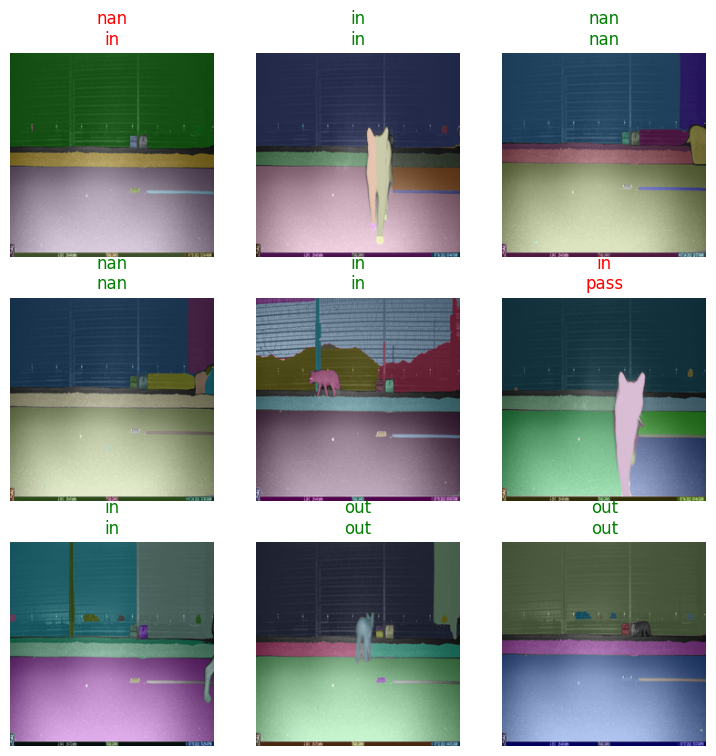

In [ ]:
learn.show_results()

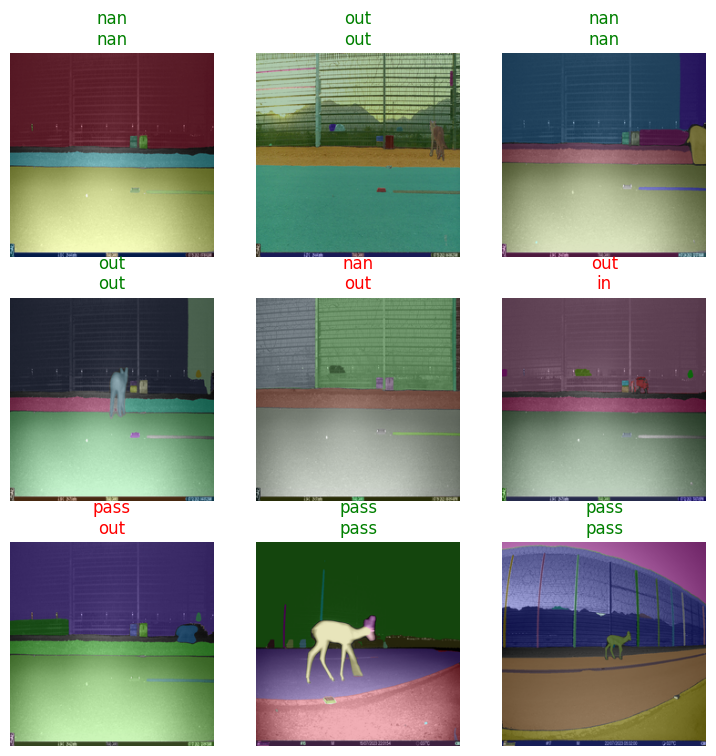

In [ ]:
learn.show_results()

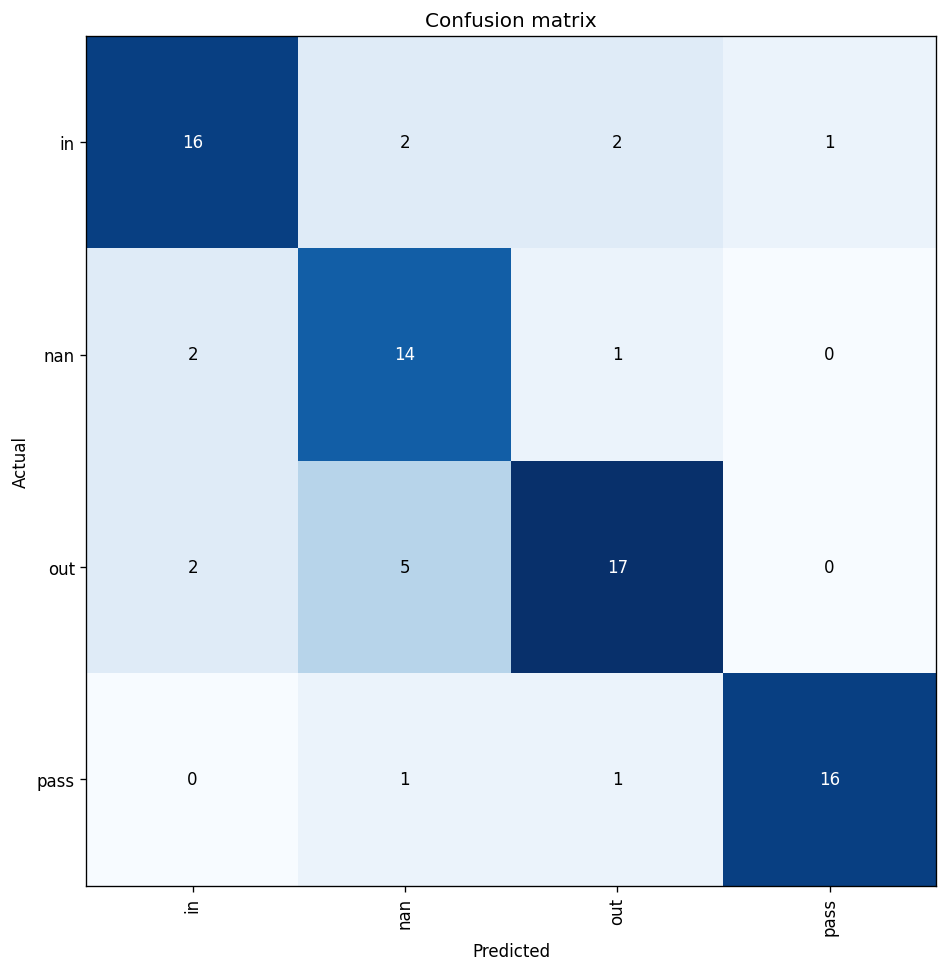

In [ ]:
cinterp = ClassificationInterpretation.from_learner(learn)
cinterp.plot_confusion_matrix(figsize=(8,8), dpi=120)

In [ ]:
learn.save('fastai_resnet34_in_out_v1')

Path('/content/SAM_animal_pics/models/fastai_resnet34_in_out_v1.pth')